In [81]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

plt.style.use('guide.mplstyle')

In [82]:
calibrated_data = Path('..', 'bias-reduced')
calibrated_data.mkdir(exist_ok=True)

In [83]:
bias_files = Path('..', '2022_03_20', 'Bias') # = 22022_03_20/Bias
files = ccdp.ImageFileCollection(bias_files)

In [84]:
files.summary[:5]

file,simple,bitpix,naxis,naxis1,naxis2,extend,bzero,bscale,roworder,instrume,telescop,observer,object,exptime,ccd-temp,pixsize1,pixsize2,xbinning,ybinning,xpixsz,ypixsz,frame,imagetyp,filter,focallen,aptdia,scale,date-obs,gain,offset,comment
str27,bool,int32,int32,int32,int32,bool,int32,int32,str8,str21,str7,str7,str7,float64,float64,float64,float64,int32,int32,float64,float64,str4,str10,str3,float64,float64,float64,str23,float64,float64,str162
Bias_0.000032_secs_001.fits,True,16,2,4656,3520,True,32768,1,TOP-DOWN,ZWO CCD ASI1600MM Pro,SynScan,Unknown,Unknown,3.2e-05,-5.0,3.8,3.8,1,1,3.8,3.8,Bias,Bias Frame,SII,1600.0,200.0,0.4899625,2022-03-21T15:40:46.934,139.0,10.0,"FITS (Flexible Image Transport System) format is defined in 'Astronomy, and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,Generated by INDI"
Bias_0.000032_secs_002.fits,True,16,2,4656,3520,True,32768,1,TOP-DOWN,ZWO CCD ASI1600MM Pro,SynScan,Unknown,Unknown,3.2e-05,-5.0,3.8,3.8,1,1,3.8,3.8,Bias,Bias Frame,SII,1600.0,200.0,0.4899625,2022-03-21T15:40:55.842,139.0,10.0,"FITS (Flexible Image Transport System) format is defined in 'Astronomy, and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,Generated by INDI"
Bias_0.000032_secs_003.fits,True,16,2,4656,3520,True,32768,1,TOP-DOWN,ZWO CCD ASI1600MM Pro,SynScan,Unknown,Unknown,3.2e-05,-5.0,3.8,3.8,1,1,3.8,3.8,Bias,Bias Frame,SII,1600.0,200.0,0.4899625,2022-03-21T15:41:01.705,139.0,10.0,"FITS (Flexible Image Transport System) format is defined in 'Astronomy, and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,Generated by INDI"
Bias_0.000032_secs_004.fits,True,16,2,4656,3520,True,32768,1,TOP-DOWN,ZWO CCD ASI1600MM Pro,SynScan,Unknown,Unknown,3.2e-05,-5.0,3.8,3.8,1,1,3.8,3.8,Bias,Bias Frame,SII,1600.0,200.0,0.4899625,2022-03-21T15:41:08.115,139.0,10.0,"FITS (Flexible Image Transport System) format is defined in 'Astronomy, and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,Generated by INDI"
Bias_0.000032_secs_005.fits,True,16,2,4656,3520,True,32768,1,TOP-DOWN,ZWO CCD ASI1600MM Pro,SynScan,Unknown,Unknown,3.2e-05,-5.0,3.8,3.8,1,1,3.8,3.8,Bias,Bias Frame,SII,1600.0,200.0,0.4899625,2022-03-21T15:41:14.401,139.0,10.0,"FITS (Flexible Image Transport System) format is defined in 'Astronomy, and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,Generated by INDI"


In [85]:
path_to_combined_bias = Path(calibrated_data, 'combined_bias.fit')
if path_to_combined_bias.is_file():
    print('File exists,no combination necessary')
else:
    calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)
    combined_bias = ccdp.combine(calibrated_biases,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6, unit = 'adu'
                                 )

    combined_bias.meta['combined'] = True
    combined_bias.write(calibrated_data / 'combined_bias.fit', overwrite = False)

File exists,no combination necessary


Text(0.5, 1.0, '25 bias images combined')

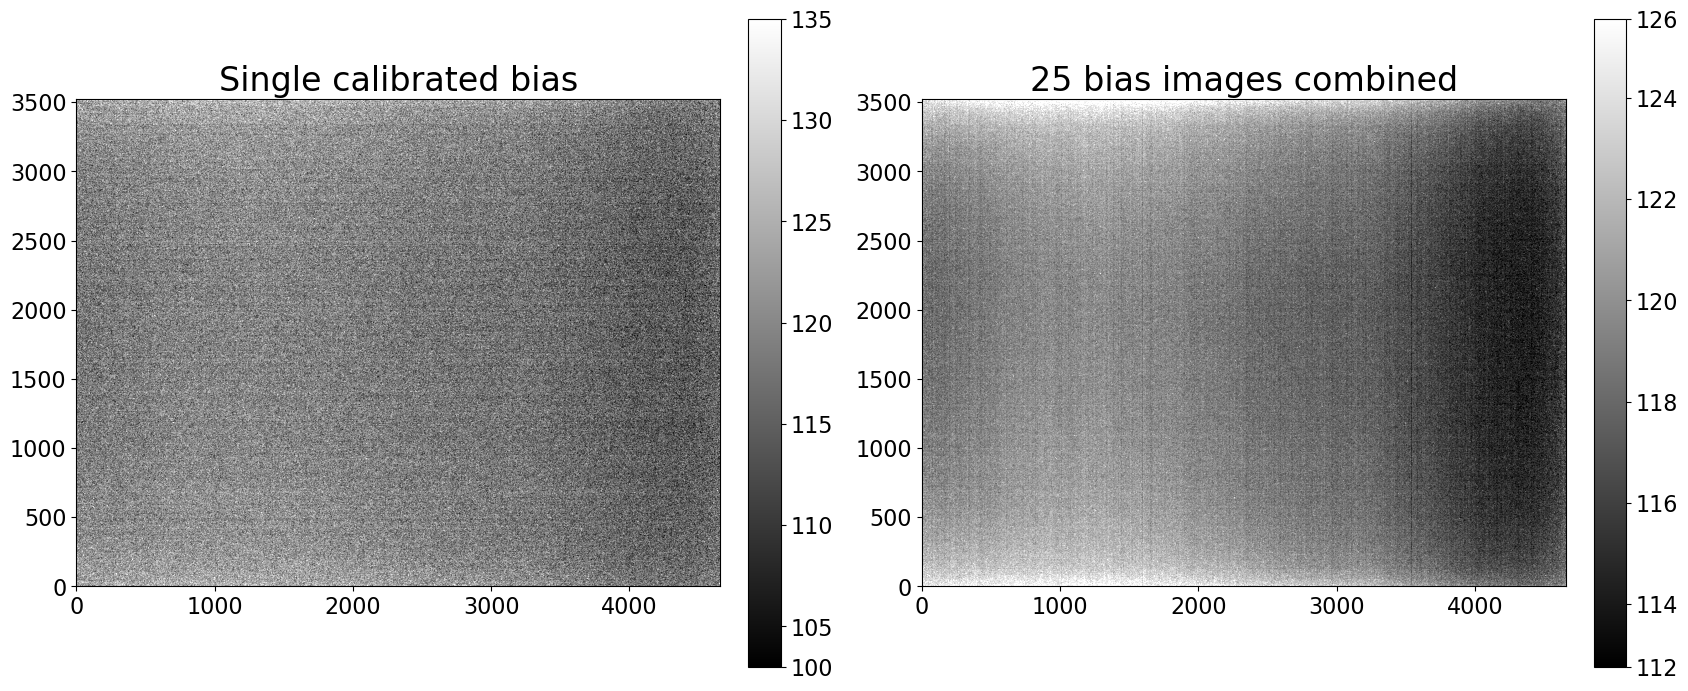

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(calibrated_biases[0], unit = 'adu').data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Single calibrated bias')
show_image(combined_bias.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('{} bias images combined'.format(len(calibrated_biases)))

# Combining darks by exposure time
Since we have darks for the different exposure times we don't need to subtract the BIAS in the files, and no calibration is necessary.

In [88]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

In [89]:
calibrated_darks_path = Path('..', 'darks-reduced')
calibrated_darks_path.mkdir(exist_ok=True)

In [90]:
dark_files_path = Path('..', '2022_03_20', 'Dark')
dark_files = ccdp.ImageFileCollection(dark_files_path)

In [91]:
darks = dark_files.summary['imagetyp'] == 'Dark Frame'
dark_times = set(dark_files.summary['exptime'][darks])
print(dark_times)

{32.0, 0.01, 0.0032, 16.0, 0.02}


In [92]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [93]:
for exp_time in sorted(dark_times):
    path_dark_file = Path(calibrated_darks_path, f'combined_dark_{exp_time}.fit')
    if path_dark_file.is_file():
        print(f'Master dark for {exp_time} already exists')
    else:
        calibrated_darks = dark_files.files_filtered(imagetyp='Dark Frame', exptime=exp_time,
                                                         include_path=True)

        combined_dark = ccdp.combine(calibrated_darks,
                                     method='average',
                                     sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                     sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                     mem_limit=350e6, unit = 'adu', verbose = False
                                     )

        combined_dark.meta['combined'] = True

        dark_file_name = f'combined_dark_{exp_time}.fit'
        combined_dark.write(calibrated_darks_path / dark_file_name)


Master dark for 0.0032 already exists
Master dark for 0.01 already exists
Master dark for 0.02 already exists
Master dark for 16.0 already exists
Master dark for 32.0 already exists


Text(0.5, 1.0, '10 dark images combined')

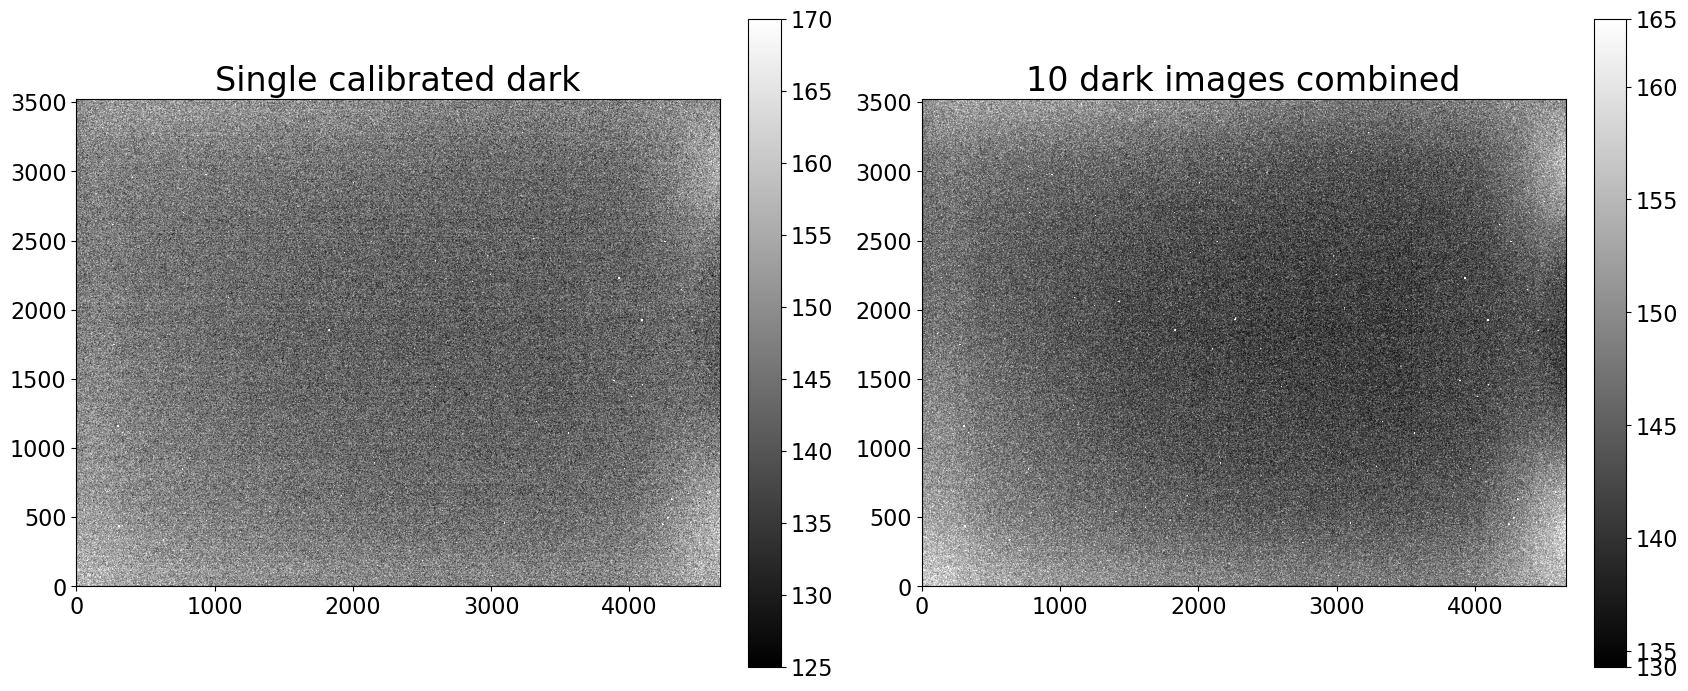

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(calibrated_darks[0], unit = 'adu').data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Single calibrated dark')
show_image(combined_dark.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('{} dark images combined'.format(len(calibrated_darks)))

# Combined Flats

In [96]:
def find_nearest_dark_exposure(image, dark_exposure_times, tolerance=0.5):
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.

    Parameters
    ----------

    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.

    dark_exposure_times : list
        Exposure times for which there are darks.

    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.

    Returns
    -------

    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - image.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and
            np.abs(image.header['exptime'] - closest_dark_exposure) > tolerance):

        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, image.header['exptime']))


    return closest_dark_exposure

In [97]:
from pathlib import Path

from astropy import units as u
from astropy.nddata import CCDData
import ccdproc as ccdp
from matplotlib import pyplot as plt
import numpy as np

from convenience_functions import show_image

In [98]:
reduced_path = Path('..', 'darks-reduced')
destination_path = Path('..', 'reduced-flats')
destination_path.mkdir( exist_ok = True)

ifc_reduced = ccdp.ImageFileCollection(reduced_path)

combined_dark_files = ifc_reduced.files_filtered(imagetyp='Dark Frame', combined=True)

flat_image_type = 'FLATFIELD'

In [99]:
raw_data = Path('..', '2022_03_20', 'Flat', 'Luminance')

ifc_raw = ccdp.ImageFileCollection(raw_data)

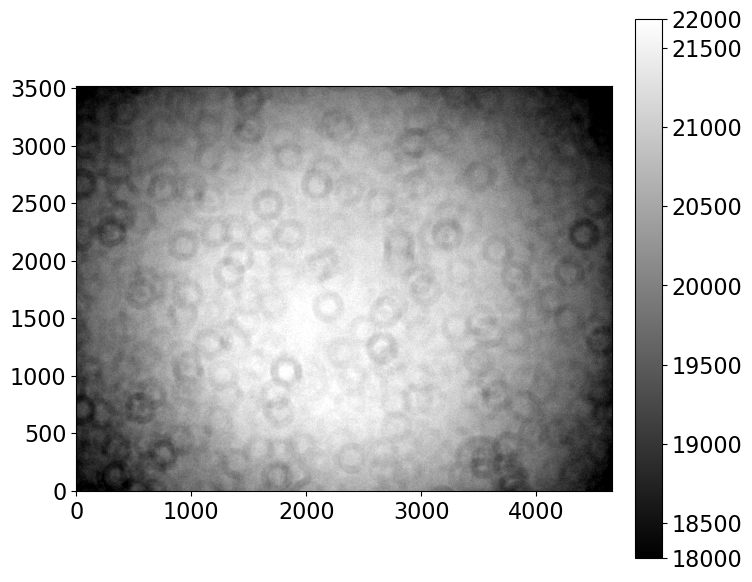

In [100]:
a_flat = CCDData.read(ifc_raw.files_filtered(imagetyp='Flat Frame', include_path=True)[0], unit='adu')

show_image(a_flat, cmap='gray')

In [101]:
actual_exposure_times = set(h['exptime'] for h in ifc_reduced.headers(imagetyp='Dark Frame', combined=True))

In [102]:
closest_dark = find_nearest_dark_exposure(a_flat, actual_exposure_times)

In [103]:
combined_darks = {ccd.header['exptime']: ccd for ccd in ifc_reduced.ccds(imagetyp='Dark Frame', combined=True)}

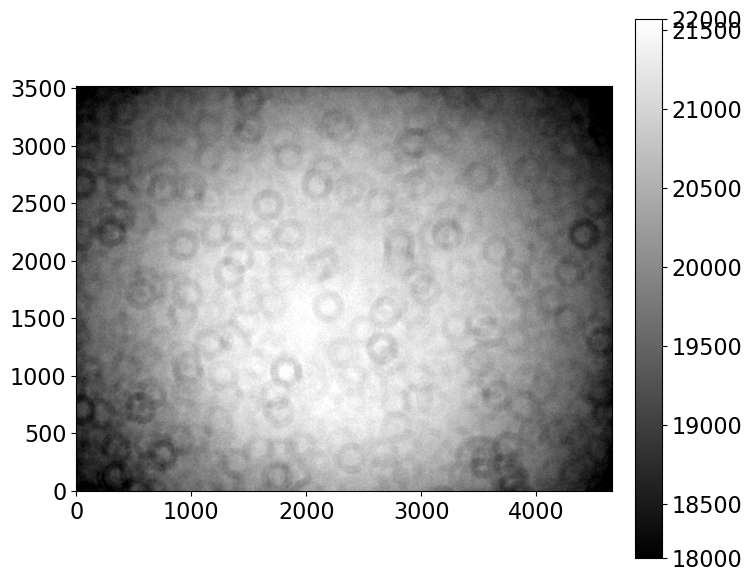

In [104]:
a_flat_reduced = ccdp.subtract_dark(a_flat, combined_darks[closest_dark],
                                    exposure_time='exptime', exposure_unit=u.second, scale=False)
show_image(a_flat_reduced, cmap='gray')

In [105]:
for ccd, file_name in ifc_raw.ccds(imagetyp='Flat Frame',  # Just get the flat frames
                                   ccd_kwargs={'unit': 'adu'},  # CCDData requires a unit for the image if
                                   # it is not in the header
                                   return_fname=True  # Provide the file name too.
                                   ):
    path_flat_file = Path('..', 'reduced-flats', 'flat-'+file_name)
    if path_flat_file.is_file():
        print('File already exists')
    else:
        # Find the correct dark exposure
        closest_dark = find_nearest_dark_exposure(ccd, actual_exposure_times)

        # Subtract the dark current
        ccd = ccdp.subtract_dark(ccd, combined_darks[closest_dark],
                                 exposure_time='exptime', exposure_unit=u.second)

        # Save the result; there are some duplicate file names so pre-pend "flat"
        ccd.write(destination_path / ('flat-' + file_name))

File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists


# Combining Flats

In [106]:
calibrated_flat_path = Path('..', 'reduced-flats')

flat_imagetyp = 'Flat Frame'

ifc = ccdp.ImageFileCollection(calibrated_flat_path)

In [107]:
flat_filters = set(h['filter'] for h in ifc.headers(imagetyp=flat_imagetyp))
flat_filters

{'Luminance'}

In [108]:
def inv_median(a):
    return 1 / np.median(a)

In [109]:
for filt in flat_filters:
    path_flat_file = Path(calibrated_flat_path, 'combined_flat_filter_{}.fit'.format(filt.replace("''", "p")))
    if path_flat_file.is_file():
        print(f'Master flat for filter {filt} already exists')
    else:
        to_combine = ifc.files_filtered(imagetyp=flat_imagetyp, filter=filt, include_path=True)
        combined_flat = ccdp.combine(to_combine,
                                     method='average', scale=inv_median,
                                     sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                     sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                     mem_limit=350e6
                                     )

        combined_flat.meta['combined'] = True
        flat_file_name = 'combined_flat_filter_{}.fit'.format(filt.replace("''", "p"))
        combined_flat.write(calibrated_flat_path / flat_file_name)

Master flat for filter Luminance already exists


In [110]:
ifc.refresh()
ifc.files_filtered(imagetyp=flat_imagetyp, combined=True)

array(['combined_flat_filter_Luminance.fit'], dtype='<U39')

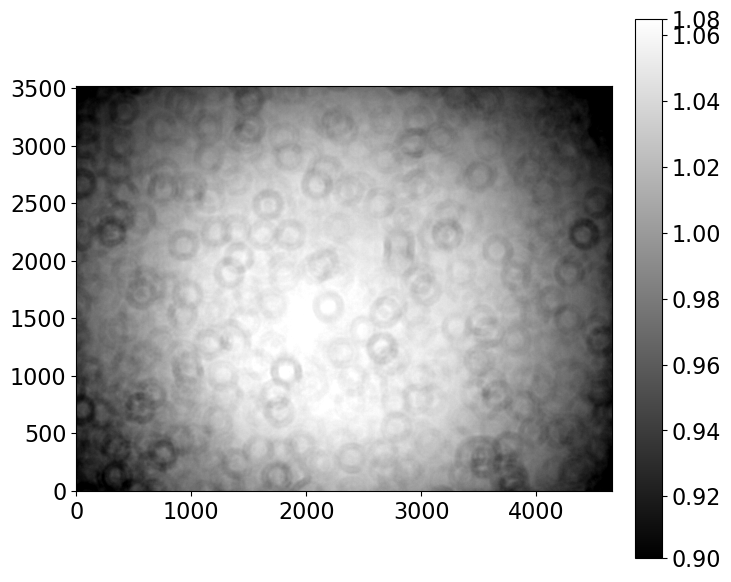

In [111]:
show_image(combined_flat, cmap = 'gray')